 # Dueling Deep Q Network

 ## Imports

In [1]:
import gym, math, glob
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta
from environments.BHS.environment_v4_0 import Environment


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from utils.wrappers import *
from agents.DQN import Model as DQN_Agent
from utils.ReplayMemory import ExperienceReplayMemory

from utils.hyperparameters import Config
from utils.plot import plot_all_data



 ## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#epsilon variables
config.epsilon_start = 1.0
config.epsilon_final = 0.01
config.epsilon_decay = 30000
config.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

#misc agent variables
config.GAMMA=0.99
config.LR=1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE = 100000
config.BATCH_SIZE = 32

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES=50000
config.UPDATE_FREQ = 1

#Nstep controls
config.N_STEPS=1

#data logging parameters
config.ACTION_SELECTION_COUNT_FREQUENCY = 1000

 ## Network

In [3]:
class BHSDuelingDQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(BHSDuelingDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_outputs # a vector of the number of actions at each diverter
        self.conv1 = nn.Conv2d(self.input_shape[0], 128, kernel_size=[3,1], stride=1, padding=[1,0])
        self.conv2_1 = nn.Conv2d(128, 64, kernel_size=[3,1], stride=1, padding=[1,0])
        self.conv2_2 = nn.Conv2d(128, 64, kernel_size=[5,1], stride=1, padding=[2,0])
        self.conv2_3 = nn.Conv2d(128, 64, kernel_size=[7,1], stride=1, padding=[3,0])
        
        self.conv3 = nn.Conv2d(64*3, 128, kernel_size=[3,1], stride=1, padding=[1,0])
        self.conv4 = nn.Conv2d(128, 128, kernel_size=[3,1], stride=1, padding=[1,0])
        self.conv5 = nn.Conv2d(128, 128, kernel_size=[3,1], stride=1, padding=[1,0])
        self.adv = nn.Linear(self.feature_size(), sum(self.num_actions)) # Might be an idea to add another fc layer here

        self.val1 = nn.Linear(self.feature_size(), 64)
        self.val2 = nn.Linear(64, 64)
        self.val3 = nn.Linear(64, len(self.num_actions))

    def forward(self, x):
        x = x[:,:,None,:]
        x = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2_1(x))
        x2 = F.relu(self.conv2_2(x))
        x3 = F.relu(self.conv2_3(x))
        x = torch.cat((x1,x2,x3),1)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)
        
        adv = F.relu(self.adv(x))
        adv = adv.view(adv.size(0),len(self.num_actions),-1)

        val = F.relu(self.val1(x))
        val = F.relu(self.val2(val))
        val = self.val3(val)
        
        return val.unsqueeze(-1).expand_as(adv) + adv - adv.mean(-1).unsqueeze(-1).expand_as(adv)
    
    def feature_size(self):
        return self.conv5(
            self.conv4(
                self.conv3(
                    torch.cat(
                        (self.conv2_1(
                            self.conv1(torch.zeros(1, self.input_shape[0],1,self.input_shape[1]))),
                         self.conv2_2(
                             self.conv1(torch.zeros(1, self.input_shape[0],1,self.input_shape[1]))),
                         self.conv2_3(
                             self.conv1(torch.zeros(1, self.input_shape[0],1,self.input_shape[1])))),
                         1)
                ))).view(1, -1).size(1)
    
    def sample_noise(self):
        #ignore this for now
        pass


 ## Agent

In [4]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None, log_dir='/tmp/gym'):
        super(Model, self).__init__(static_policy, env, config, log_dir=log_dir)

    def declare_networks(self):
        self.model = BHSDuelingDQN(self.env.observation_space.shape, self.env.action_space.nvec)
        self.target_model = BHSDuelingDQN(self.env.observation_space.shape, self.env.action_space.nvec)


 ## Training Loop

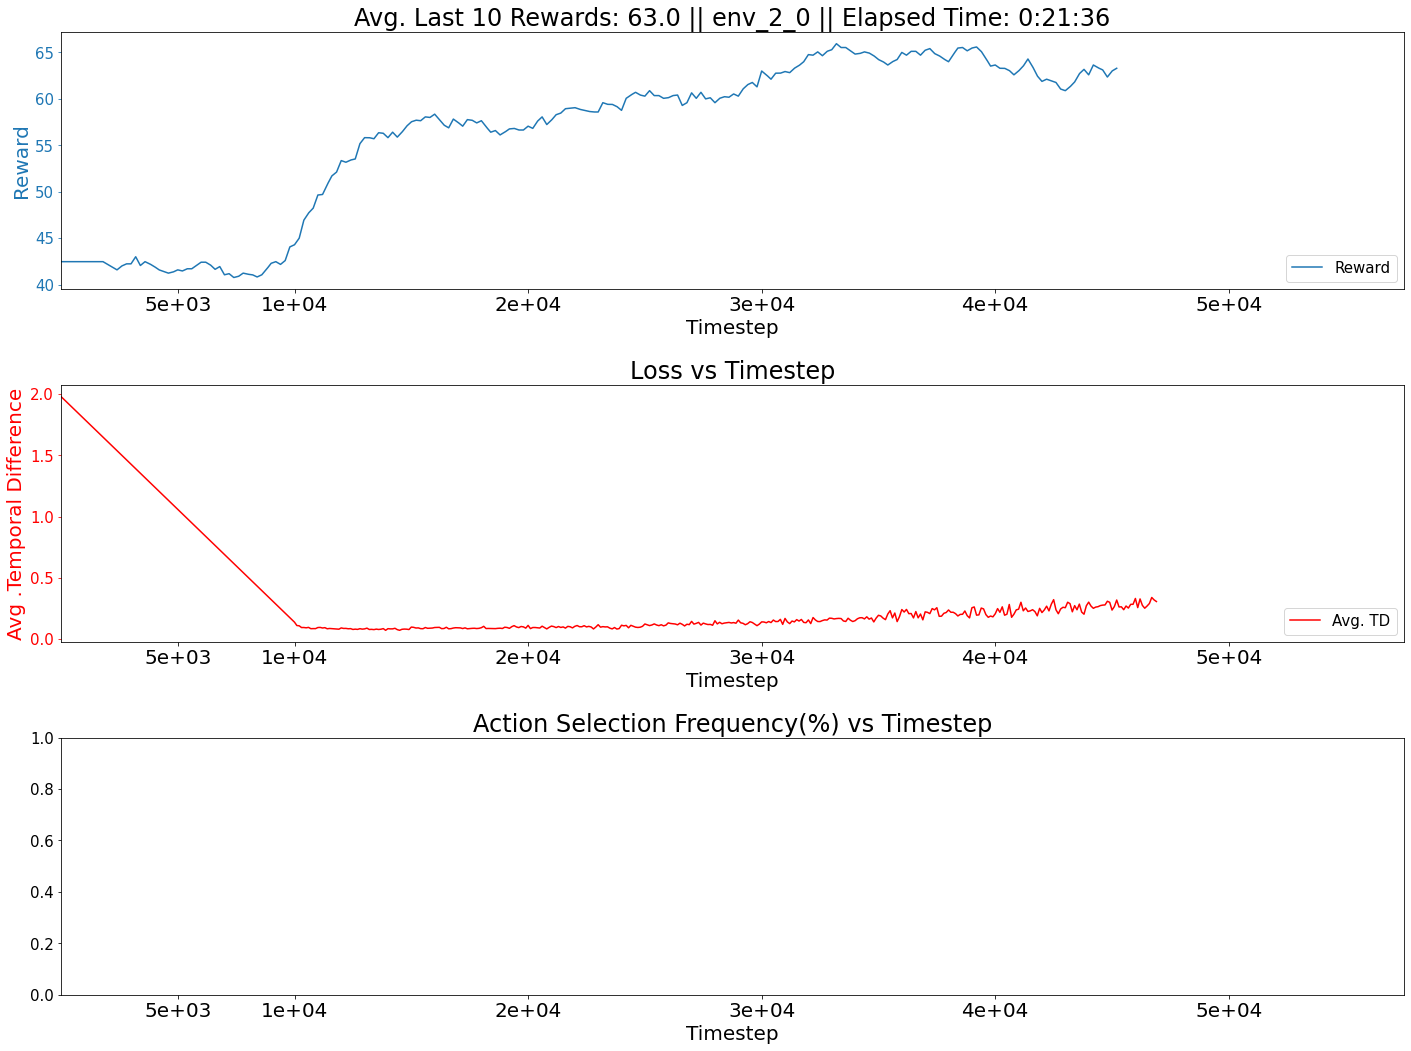

In [ ]:
start=timer()

log_dir = "tmp/gym/"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

class Arg_parser():
    def __init__(self):
        self.max_timesteps = 10000000
        self.envtype = 'env_2_0'
        self.tb_log_name = 'DQN'
        self.steplimit = 200
        self.log_interval = 10
        self.step_penalty = None
        self.trasum_scale = None
        self.destination_score = None
        self.numtotes = 30
        self.randomize_numtotes = False
        self.RL_diverters = None
    
args = Arg_parser()

        
env_id = args.envtype
env    = Environment(args) #make_atari(env_id)
env    = bench.Monitor(env, os.path.join(log_dir, env_id))
# env    = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=True)
# env    = ImageToPyTorch(env)
model  = Model(env=env, config=config, log_dir=log_dir)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)[0]
    model.save_action(action, frame_idx) #log action selection

    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0
    
    
    if frame_idx % 1000 == 0:
        print(frame_idx)
        
        model.save_w()
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'BHSDuelingDQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass

model.save_w()
env.close()
plot_all_data(log_dir, env_id, 'BHSDuelingDQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)